# **Two fold cross validation for logistic regression and baseline**

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score
import pandas as pd

## Load dataset

In [3]:
filename = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(filename)
y = df['DEATH_EVENT']
X = df.drop(['DEATH_EVENT'], axis = 1)
attributeNames = list(X.keys())
X = X.to_numpy()
y = y.to_numpy()

mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu) / sigma
classNames = "DEATH_EVENT"
N, M = X.shape
C = 2

## Define our models

We are going to define two models:

- A baseline model
- A logistic regression model
- A neural network

### Baseline

In [3]:
# In our dataset there are more entries of the class 0 (Survived)
# The best possible accuracy will be around 70% given our dataset
def baseline(dataset):
    dataset_index = dataset.index
    baseline = pd.Series(np.zeros(300)).astype(int)
    baseline = baseline.iloc[dataset_index]
    return baseline


### Logistic regression

In [4]:

log_reg = lambda regularization: LogisticRegression(penalty="l2", C= 1/regularization, max_iter= 5000)

### ANN

In [5]:
nn = lambda n_hidden_units: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

In [6]:
# From course Introduction to Machine learning and data mining toolbox
def train_neural_net(model, loss_fn, X, y, n_hidden_units,
                     n_replicates=1, max_iter = 10000, tolerance=1e-6):
    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100
    for r in range(n_replicates):
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model(n_hidden_units)
        
        # initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)
                     
        # We can optimize the weights by means of stochastic gradient descent
        # The learning rate, lr, can be adjusted if training doesn't perform as
        # intended try reducing the lr. If the learning curve hasn't converged
        # (i.e. "flattend out"), you can try try increasing the maximum number of
        # iterations, but also potentially increasing the learning rate:
        #optimizer = torch.optim.SGD(net.parameters(), lr = 5e-3)
        
        # A more complicated optimizer is the Adam-algortihm, which is an extension
        # of SGD to adaptively change the learing rate, which is widely used:
        optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict labels on training set
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() #get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # display loss with some frequency:
            # do backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # display final loss
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
            best_hidden_unit = n_hidden_units
        
    # Return the best curve along with its final loss and learing curve
    return best_net

## Two fold cross-validation

In [7]:

y.squeeze()

# Variables to control fold splits
K1 = 10
K2 = 10

# Initialize variables
lambda_interval = np.logspace(-5, 1, 10) # Holds regularization values for our logistic regression model
hidden_units_interval = [1, 2, 3, 4, 5] # Holds hidden units range for our neural network
final_models_lambda = []
final_models_reg_error = []
final_models_hidden_unit = []
final_models_nn_error = []
final_baseline_error = []
Baseline_pred = []
Logistic_pred = []
Network_pred = []
Y_true = []
Error_test = np.empty((K1,1))
Validation_error_nn = np.zeros((len(hidden_units_interval), K2))
Validation_error_reg = np.zeros((len(lambda_interval), K2)) 

Outer_fold = StratifiedKFold(n_splits = K1, shuffle = True)
Inner_fold =  StratifiedKFold(n_splits = K2, shuffle = True)

for i, (par_index, test_index) in enumerate(Outer_fold.split(X,y)):
    print('\nCrossvalidation outer fold: {0}/{1}'.format(i+1,K1))
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]

    Generalization_error_reg = []
    Generalization_error_nn = []
    Generalization_error_base = []
    Y_true.append(y_test)

    for j, (train_index, val_index) in enumerate(Inner_fold.split(X_par, y_par)):
        print('\nCrossvalidation inner fold: {0}/{1}'.format(j+1,K2))
        X_train, y_train = X_par[train_index, :], y_par[train_index]
        X_val, y_val = X_par[val_index], y_par[val_index]

        # Now we test our s models in regression
        for s, lambda_val in enumerate(lambda_interval):
            model  = log_reg(lambda_val)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            Validation_error_reg[s,j] = (len(y_val)/len(y_par))*(sum(y_pred != y_val)/len(y_pred))
        
        X_train_t = torch.tensor(X_train, dtype= torch.float)
        y_train_t = torch.tensor(y_train, dtype= torch.float)
        X_val_t = torch.tensor(X_val, dtype= torch.float)
        y_val_t = torch.tensor(y_val, dtype= torch.float)
        # Test for each hidden unit
        for h, n_hidden_units in enumerate(hidden_units_interval):
            net = train_neural_net(nn, loss_fn, X_train_t, y_train_t, n_hidden_units)
            y_sigmoid = net(X_val_t)
            y_test_est = (y_sigmoid>.5).type(dtype=torch.uint8)
            y_test_est = y_test_est.numpy()
            y_test_est = y_test_est.reshape(y_val.shape)
            # Determine errors and errors
            Validation_error_nn[h,j] = (len(y_val)/len(y_par)) * (sum(y_test_est != y_val)/len(y_val))
            
    
    # We compute for each model its generalization error
    for s in range(len(lambda_interval)):
        Generalization_error_reg.append(np.sum(Validation_error_reg[s, :]))

    for h in range(len(hidden_units_interval)):
        Generalization_error_nn.append(np.sum(Validation_error_nn[h, :]))


    # We select the best model and compute its test error with D_test
    min_index_reg = np.argmin(Generalization_error_reg)
    best_lambda = lambda_interval[min_index_reg]
    model = log_reg(best_lambda)
    model.fit(X_par, y_par)
    y_pred = model.predict(X_test)
    error_test_reg = sum(y_pred != y_test)/len(y_pred)
    Logistic_pred.append(y_pred)

    X_par_t = torch.tensor(X_par, dtype= torch.float)
    y_par_t = torch.tensor(y_par, dtype= torch.float)
    X_test_t = torch.tensor(X_test, dtype= torch.float)
    y_test_t = torch.tensor(y_test, dtype= torch.float)

    min_index_nn = np.argmin(Generalization_error_nn)
    best_hidden_unit = hidden_units_interval[min_index_nn]
    net = train_neural_net(nn, loss_fn, X_par_t, y_par_t, best_hidden_unit)
    y_sigmoid = net(X_test_t)
    y_test_est = (y_sigmoid>.5).type(dtype=torch.uint8)
    y_test_est = y_test_est.numpy()
    y_test_est = y_test_est.reshape(y_test.shape)
    error_test_nn = sum(y_test_est != y_test)/len(y_test)
    Network_pred.append(y_test_est)

    y_pred_baseline = baseline(pd.Series(y_test))
    
    final_baseline_error.append(sum(y_pred_baseline != y_test)/len(y_pred_baseline))
    Baseline_pred.append(y_pred_baseline)

    # We store the final models data
    final_models_lambda.append(best_lambda)
    final_models_reg_error.append(error_test_reg)
    final_models_hidden_unit.append(best_hidden_unit)
    final_models_nn_error.append(error_test_nn)

        



Crossvalidation outer fold: 1/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 2/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 3/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 4/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 5/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 6/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 7/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 8/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 9/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation outer fold: 10/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([270])) that is different to the input size (torch.Size([270, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [8]:
data = {"Outer fold": range(1, K1 + 1),
        "h": final_models_hidden_unit,
        "ANN": final_models_nn_error,
        "lambda": final_models_lambda,
        "Logistic regression": final_models_reg_error,
        "Baseline": final_baseline_error}

df = pd.DataFrame(data)
df.set_index("Outer fold")

print(df)

   Outer fold  h       ANN    lambda  Logistic regression  Baseline
0           1  4  0.266667  0.000010             0.200000  0.333333
1           2  3  0.300000  0.000010             0.133333  0.333333
2           3  5  0.233333  0.000010             0.233333  0.333333
3           4  3  0.166667  0.000215             0.266667  0.333333
4           5  4  0.266667  0.000010             0.100000  0.333333
5           6  5  0.366667  0.000046             0.100000  0.333333
6           7  4  0.366667  0.000046             0.166667  0.300000
7           8  4  0.233333  0.000010             0.166667  0.300000
8           9  2  0.233333  0.000010             0.233333  0.300000
9          10  5  0.241379  0.000010             0.172414  0.310345


In [9]:
from toolbox_02450 import mcnemar
alpha = 0.05
Baseline_pred = np.concatenate(Baseline_pred)
Logistic_pred = np.concatenate(Logistic_pred)
Network_pred =  np.concatenate(Network_pred)
Y_true = np.concatenate(Y_true)


# Compare Baseline_pred Logistic_pred
[thetahat, CI, p] = mcnemar(Y_true, Baseline_pred, Logistic_pred, alpha=alpha)
print("theta = theta_Baseline_pred-theta_Logistic_pred point estimate", thetahat, " CI: ", CI, "p-value", p)

# Compare Baseline_pred Network_pred
[thetahat, CI, p] = mcnemar(Y_true, Baseline_pred, Network_pred, alpha=alpha)
print("theta = theta_Baseline_pred-theta_Network_pred point estimate", thetahat, " CI: ", CI, "p-value", p)

# Compare Logistic_pred Network_pred
[thetahat, CI, p] = mcnemar(Y_true, Logistic_pred, Network_pred, alpha=alpha)
print("theta = theta_Logistic_pred-theta_Network_pred point estimate", thetahat, " CI: ", CI, "p-value", p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[181.  22.]
 [ 65.  31.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.20238026718466984, -0.0847434101712673)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 4.348703111758687e-06
theta = theta_Baseline_pred-theta_Logistic_pred point estimate -0.14381270903010032  CI:  (-0.20238026718466984, -0.0847434101712673) p-value 4.348703111758687e-06
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[175.  28.]
 [ 44.  52.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.10861933572400473, 0.001757317220332899)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.07636915467183139
theta = theta_Baseline_pred-theta_Network_pred point estimate -0.05351170568561873  CI:  (-0.10861933572400473, 0.001757317220332899) p-value 0.07636915467183139
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[199

Text(0, 0.5, 'E test')

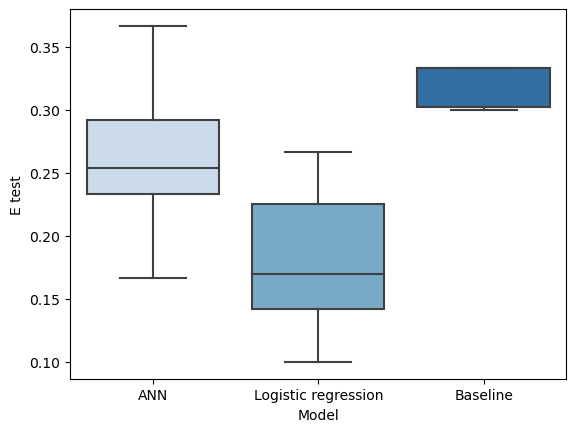

In [10]:
import seaborn as sn

df = df.drop(["lambda", "h", "Outer fold"], axis = 1)
sn.boxplot(data= df, palette="Blues")
plt.xlabel('Model')
plt.ylabel('E test')